In [41]:
N = 144
G = 1

lambda_A = G + (N % 3)
lambda_B = G + (N % 5)

N_A = 2 + (G % 2)
N_B = 1 + (N % 2)
R_A = 1 + (G % 2)
R_B = 2 - (G % 2)

lambda_S = (N_A + N_B - (G % 2)) * (G + (N % 4))

# 2.2

Задача №2

Система состоит из устройств типа A и типа B, интенсивности отказов lambda_A = 1 и lambda_B = 5 известны.
Для функционирования системы требуется хотя бы одно устройство типа A и хотя бы N_B = 1 
устройств типа B. Также имеются резервные устройства в количествах R_A = 2 и R_B = 1
соответственно, причём в нормальном состоянии одновременно включены сразу N_A = 3
устройств типа A.
Одновременно может ремонтироваться только одно устройство. Если подлежат ремонту устройства разных типов, приоритет
отдаётся тем, которых сломалось больше, а если их сломалось одинаковое число – тому
типу, интенсивность поломок которого выше. Интенсивность ремонта устройств обоих
типов одинакова и равна lambda_S = 3.

Требуется:
1. нарисовать граф состояний системы;
2. составить матрицу интенсивностей переходов;
3. записать алгебраические уравнения Колмогорова для установившегося режима
работы;
4. рассчитать предельные вероятности состояний системы;
5. рассчитать математические ожидания прикладных характеристик системы:
    ● вероятности отказа системы;
    ● числа готовых к эксплуатации устройств каждого типа;
    ● коэффициента загрузки ремонтной службы.
6. записать дифференциальные уравнения Колмогорова;
7. методами численного интегрирования решить полученную систему
дифференциальных уравнений, исходя из того, что в начальный момент времени все
устройства исправны, а время моделирования выбирается вдвое больше теоретической
оценки времени переходного процесса (т.е. того времени, которое необходимо, чтобы
эвклидова норма вектора невязки с ранее рассчитанным предельным вектором
составляла не более 1% эвклидовой нормы последнего);
8. построить графики вероятностей нахождения системы в каждом из возможных
состояний с течением времени;
9. провести имитационное моделирование системы в терминах непрерывных марковских
цепей 1 раз, время моделирования определяется расчётом в п.7;
10. провести имитационное моделирование системы в терминах дискретно-событийного
моделирования (с независимым планированием времени наступления событий для
каждого устройства в отдельности) 1 раз, время моделирования определяется расчётом
в п.7.

# 2.2.1 Граф с ремонтами

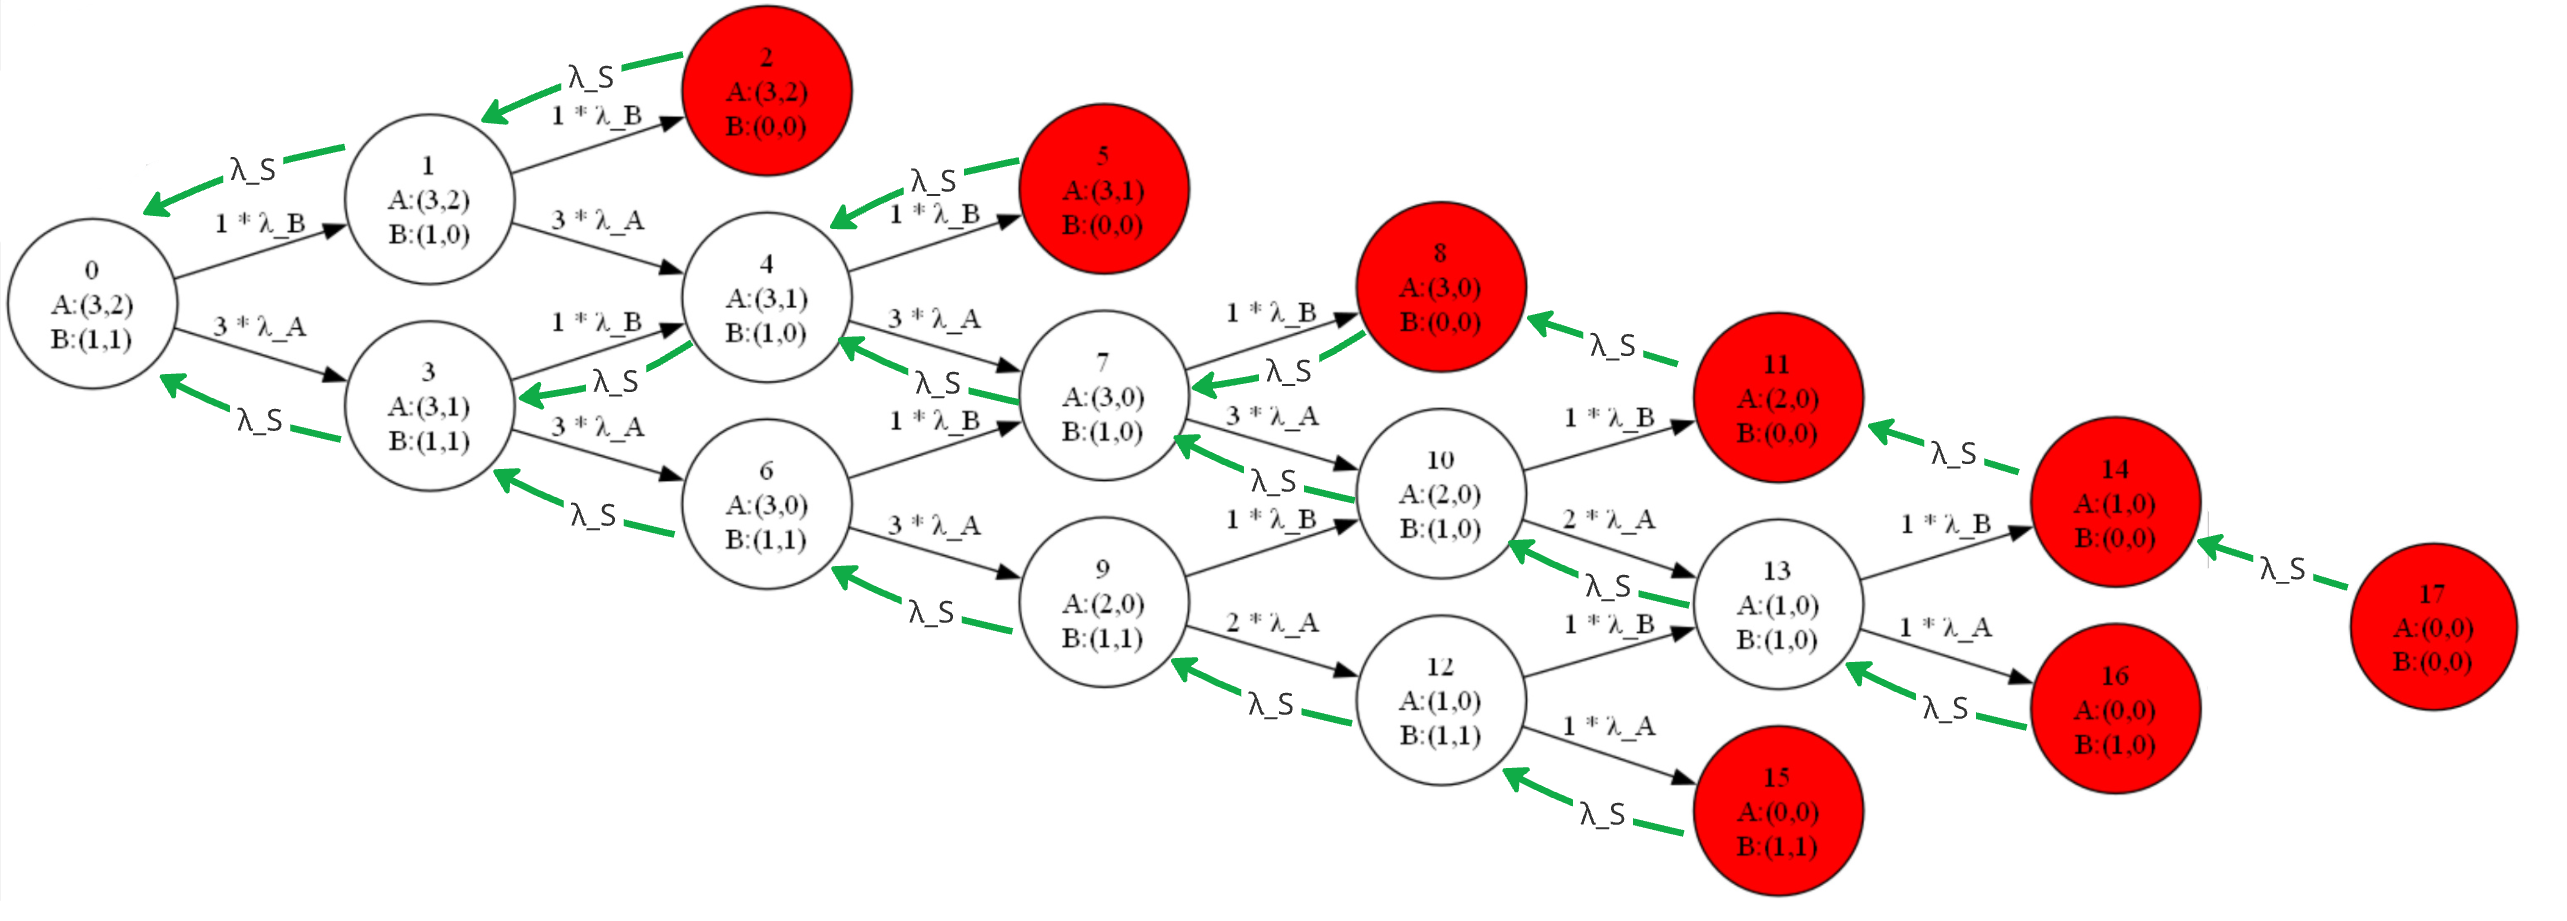

In [42]:

from IPython.display import Image
Image(r'C:\YandexDisk\8 семестр\АМИИМНАСУ\2.2\Мой шедевр.png')

# 2.2.2 Матрица интенсивностей переходов

In [43]:
from math import isclose

def build_Q_matrix_cold_standby():
    """
    Формируем матрицу (список списков строк) Q для модели холодного резерва.
    Порядок состояний:
      i -> (a_act, a_res, b_act, b_res),
    где:
      states_A = [(3,2), (3,1), (3,0), (2,0), (1,0), (0,0)]
      states_B = [(1,1), (1,0), (0,0)]
    Итого N=18 состояний.
    
    Возвращает (список_состояний, матрица_Q),
    где матрица_Q - это список списков строк, например Q[i][j] = "3*λ_A" или "0".
    На диагонали Q[i][i] будет что-то вроде "-(3*λ_A + 1*λ_B)".
    """
    states_A = [(3,2), (3,1), (3,0), (2,0), (1,0), (0,0)]
    states_B = [(1,1), (1,0), (0,0)]
    
    composite_states = []
    for a_state in states_A:
        for b_state in states_B:
            composite_states.append((
                a_state[0], a_state[1], 
                b_state[0], b_state[1]
            ))
    
    N = len(composite_states)  # 18
    
    state_to_id = { s:i for i,s in enumerate(composite_states) }
    
    # Изначально Q[i][j] = "0"
    Q = [["0" for _ in range(N)] for __ in range(N)]
    
    # Функция для "сложения" строковых интенсивностей
    # add_rates("3*λ_A", "2*λ_B") -> "3*λ_A + 2*λ_B"
    # add_rates("0", "5*λ_A") -> "5*λ_A"
    def add_rates(rate1, rate2):
        if rate1 == "0":
            return rate2
        if rate2 == "0":
            return rate1
        return rate1 + " + " + rate2
    

    # Заполняем внедиагональные элементы
    for i, state in enumerate(composite_states):
        a_act, a_res, b_act, b_res = state
        
        # Если состояние поглощающее (a_act=0 или b_act=0), переходов нет
        if a_act == 0 or b_act == 0:
            continue
        
        # Отказ устройства A:
        if a_act > 0:
            rate_A = f"{a_act}*λ_A"
            if a_res > 0:
                new_state = (a_act, a_res - 1, b_act, b_res)
            else:
                new_state = (a_act - 1, 0, b_act, b_res)
            
            j = state_to_id[new_state]
            Q[i][j] = add_rates(Q[i][j], rate_A)
        
        # Отказ устройства B:
        if b_act > 0:
            rate_B = f"{b_act}*λ_B"
            if b_res > 0:
                new_state = (a_act, a_res, b_act, b_res - 1)
            else:
                new_state = (a_act, a_res, b_act - 1, 0)
            
            j = state_to_id[new_state]
            Q[i][j] = add_rates(Q[i][j], rate_B)
        
    # Починки
    for i, state in enumerate(composite_states):
        a_act, a_res, b_act, b_res = state

        if a_act + a_res + b_act + b_res == N_A + R_A + N_B + R_B:
            # print("continue with ", state)
            continue

        if (N_A - a_act + R_A - a_res) > (N_B - b_act + R_B - b_res):
            if N_A - a_act != 0:
                new_state = (a_act + 1, a_res, b_act, b_res)
            else:
                new_state = (a_act, a_res + 1, b_act, b_res)
        elif (N_A - a_act + R_A - a_res) < (N_B - b_act + R_B - b_res):
            if N_B - b_act != 0:
                new_state = (a_act, a_res, b_act + 1, b_res)
            else:
                new_state = (a_act, a_res, b_act, b_res + 1)
        else:
            if lambda_A > lambda_B:
                if N_A - a_act != 0:
                    new_state = (a_act + 1, a_res, b_act, b_res)
                else:
                    new_state = (a_act, a_res + 1, b_act, b_res)
            else:
                if N_B - b_act != 0:
                    new_state = (a_act, a_res, b_act + 1, b_res)
                else:
                    new_state = (a_act, a_res, b_act, b_res + 1)

        j = state_to_id[new_state]
        Q[i][j] = Q[i][j] + " + λ_S"

    
    # Теперь диагональ: Q[i][i] = - (сумма выходов из i)
    def join_nonzero(rates):
        # Объединяем ["3*λ_A", "2*λ_B"] -> "3*λ_A + 2*λ_B"
        non_zero = [r for r in rates if r != "0"]
        if not non_zero:
            return "0"
        return " + ".join(non_zero)
    
    for i in range(N):
        # Сумма внедиагональных в i-й строке
        out_rates = join_nonzero(Q[i][j] for j in range(N) if j != i)
        if out_rates == "0":
            Q[i][i] = "0"  # нет исходящих переходов
        else:
            Q[i][i] = f"-({out_rates})"
    
    return composite_states, Q


def build_Q_matrix_cold_standby_numeric(lambda_A=1.0, lambda_B=5.0):
    """
    Строим числовую матрицу интенсивностей Q (18x18) для цепи Маркова
    с холодным резервом (без ремонтов).
    
    Состояния перечислены в порядке:
       states_A = [(3,2), (3,1), (3,0), (2,0), (1,0), (0,0)]
       states_B = [(1,1), (1,0), (0,0)]
    Затем берём декартово произведение (a_act,a_res,b_act,b_res).
    
    Возвращает:
      states_list (список длины 18),
      Q (np.array размера (18,18)).
    """
    states_A = [(3,2), (3,1), (3,0), (2,0), (1,0), (0,0)]
    states_B = [(1,1), (1,0), (0,0)]
    
    # Все комбинации
    composite_states = []
    for a_state in states_A:
        for b_state in states_B:
            composite_states.append((
                a_state[0], a_state[1],  # a_act, a_res
                b_state[0], b_state[1]   # b_act, b_res
            ))
    
    N = len(composite_states)  # 18
    state_to_id = { s:i for i,s in enumerate(composite_states) }
    
    Q = np.zeros((N, N), dtype=float)
    
    # Заполняем внедиагональные элементы
    for i, (a_act, a_res, b_act, b_res) in enumerate(composite_states):
        
        # Если состояние - поглощающее (a_act=0 или b_act=0), переходов нет
        if a_act == 0 or b_act == 0:
            continue
        
        # Отказ одного из a_act устройств A
        if a_act > 0:
            rateA = a_act * lambda_A
            if a_res > 0:
                new_state = (a_act, a_res - 1, b_act, b_res)
            else:
                new_state = (a_act - 1, 0, b_act, b_res)
            j = state_to_id[new_state]
            Q[i, j] += rateA
        
        # Отказ одного из b_act устройств B
        if b_act > 0:
            rateB = b_act * lambda_B
            if b_res > 0:
                new_state = (a_act, a_res, b_act, b_res - 1)
            else:
                new_state = (a_act, a_res, b_act - 1, 0)
            j = state_to_id[new_state]
            Q[i, j] += rateB
    
    # Починки
    for i, state in enumerate(composite_states):
        a_act, a_res, b_act, b_res = state

        if a_act + a_res + b_act + b_res == N_A + R_A + N_B + R_B:
            # print("continue with ", state)
            continue

        if (N_A - a_act + R_A - a_res) > (N_B - b_act + R_B - b_res):
            if N_A - a_act != 0:
                new_state = (a_act + 1, a_res, b_act, b_res)
            else:
                new_state = (a_act, a_res + 1, b_act, b_res)
        elif (N_A - a_act + R_A - a_res) < (N_B - b_act + R_B - b_res):
            if N_B - b_act != 0:
                new_state = (a_act, a_res, b_act + 1, b_res)
            else:
                new_state = (a_act, a_res, b_act, b_res + 1)
        else:
            if lambda_A > lambda_B:
                if N_A - a_act != 0:
                    new_state = (a_act + 1, a_res, b_act, b_res)
                else:
                    new_state = (a_act, a_res + 1, b_act, b_res)
            else:
                if N_B - b_act != 0:
                    new_state = (a_act, a_res, b_act + 1, b_res)
                else:
                    new_state = (a_act, a_res, b_act, b_res + 1)

        j = state_to_id[new_state]
        Q[i][j] = Q[i][j] + lambda_S


    # Диагональ: Q[i,i] = -sum_{j != i} Q[i,j]
    for i in range(N):
        row_sum = np.sum(Q[i, :])
        Q[i, i] = -row_sum
    
    return composite_states, Q



if __name__ == "__main__":
    # Выведем матрицу построчно на экран
    # print("Список состояний (индексы строк/столбцов):")
    # for i, s in enumerate(states):
    #     print(f"{i} -> (a_act={s[0]}, a_res={s[1]}, b_act={s[2]}, b_res={s[3]})")
    
    states, Q = build_Q_matrix_cold_standby()

    print("\nМатрица интенсивностей переходов Q (в символическом виде):\n")
    for i in range(len(Q)):
        row_str = " | ".join(f"{val:>30}" for val in Q[i])
        print(f"{i:2d}: {row_str}")




Матрица интенсивностей переходов Q (в символическом виде):

 0:               -(1*λ_B + 3*λ_A) |                          1*λ_B |                              0 |                          3*λ_A |                              0 |                              0 |                              0 |                              0 |                              0 |                              0 |                              0 |                              0 |                              0 |                              0 |                              0 |                              0 |                              0 |                              0
 1:                        0 + λ_S |     -(0 + λ_S + 1*λ_B + 3*λ_A) |                          1*λ_B |                              0 |                          3*λ_A |                              0 |                              0 |                              0 |                              0 |                              0 |          

# 2.2.3-4 Алгебраические уравнения Колмагорова & Предельные вероятности

In [71]:
import numpy as np
from scipy.linalg import null_space

# Получаем матрицу Q
states, Q = build_Q_matrix_cold_standby_numeric(lambda_A, lambda_B)

# Количество состояний в системе (это зависит от вашей матрицы Q)
num_states = Q.shape[0]

# 1. Запись алгебраических уравнений Колмогорова
print("Алгебраические уравнения Колмогорова для установившегося режима:")

for i in range(num_states):
    eqn_terms = []
    for j in range(num_states):
        if Q[i, j] != 0:  # Печатаем только ненулевые элементы
            eqn_terms.append(f"{Q[i, j]} * P_{j}")
    # Уравнение для состояния i: сумма всех переходов из этого состояния должна быть 0
    print(f"Состояние {i}: {' + '.join(eqn_terms)} = 0")

# 2. Решение системы уравнений для предельных вероятностей π
# Уравнение Колмогорова для установившегося режима: π * Q = 0
# Составляем систему линейных уравнений
# Мы знаем, что сумма вероятностей в стационарном состоянии должна быть равна 1
# Таким образом, добавляем условие для нормировки суммы вероятностей

A = Q.T  # Транспонируем матрицу Q для решения π * Q = 0
A[-1, :] = 1  # Последняя строка будет соответствовать условию нормировки
b = np.zeros(num_states)
b[-1] = 1  # Условие нормировки: сумма вероятностей = 1

# Решаем систему линейных уравнений для предельных вероятностей π
pi_end = np.linalg.lstsq(A, b, rcond=None)[0]

# 3. Результат — это предельные вероятности состояний системы
print("\nПредельные вероятности состояний:")

for state, p in enumerate(pi_end):
    print(f"Состояние {state}: {p*100:10.2f}%")

# print(pi_end)
pi_end = [float(i) for i in pi_end]
# print(pi_end)




Алгебраические уравнения Колмогорова для установившегося режима:
Состояние 0: -8.0 * P_0 + 5.0 * P_1 + 3.0 * P_3 = 0
Состояние 1: 3.0 * P_0 + -11.0 * P_1 + 5.0 * P_2 + 3.0 * P_4 = 0
Состояние 2: 3.0 * P_1 + -3.0 * P_2 = 0
Состояние 3: 3.0 * P_0 + -11.0 * P_3 + 5.0 * P_4 + 3.0 * P_6 = 0
Состояние 4: 3.0 * P_3 + -11.0 * P_4 + 5.0 * P_5 + 3.0 * P_7 = 0
Состояние 5: 3.0 * P_4 + -3.0 * P_5 = 0
Состояние 6: 3.0 * P_3 + -11.0 * P_6 + 5.0 * P_7 + 3.0 * P_9 = 0
Состояние 7: 3.0 * P_4 + -11.0 * P_7 + 5.0 * P_8 + 3.0 * P_10 = 0
Состояние 8: 3.0 * P_7 + -3.0 * P_8 = 0
Состояние 9: 3.0 * P_6 + -10.0 * P_9 + 5.0 * P_10 + 2.0 * P_12 = 0
Состояние 10: 3.0 * P_7 + -10.0 * P_10 + 5.0 * P_11 + 2.0 * P_13 = 0
Состояние 11: 3.0 * P_8 + -3.0 * P_11 = 0
Состояние 12: 3.0 * P_9 + -9.0 * P_12 + 5.0 * P_13 + 1.0 * P_15 = 0
Состояние 13: 3.0 * P_10 + -9.0 * P_13 + 5.0 * P_14 + 1.0 * P_16 = 0
Состояние 14: 3.0 * P_11 + -3.0 * P_14 = 0
Состояние 15: 3.0 * P_12 + -3.0 * P_15 = 0
Состояние 16: 3.0 * P_13 + -3.0 * P_

# 2.2.5 Прикладные характеристики системы

In [45]:
import numpy as np

total_A = N_A + R_A    # всего устройств типа A
total_B = N_B + R_B    # всего устройств типа B

states, Q = build_Q_matrix_cold_standby_numeric(lambda_A, lambda_B)

def stationary_distribution(Q):
    """
    Решаем Q^T π = 0,  sum(π)=1.
    Устраняем одну строку, заменяя её условием нормировки.
    """
    n = Q.shape[0]
    A = Q.T.copy()
    b = np.zeros(n)
    # заменяем последнюю строку на условие sum(π)=1
    A[-1,:] = 1.0
    b[-1] = 1.0
    π = np.linalg.solve(A, b)
    return π

def compute_performance(π, states):
    n = len(states)
    # 1) Вероятность отказа: активных A < 1 или активных B < 1
    fail_idx = [
        i for i,(a,_,b,_) in enumerate(states)
        if (a < 1) or (b < 1)
    ]
    P_fail = π[fail_idx].sum()

    # 2) Среднее число работающих устройств A и B
    E_A = sum(π[i] * state[0] for i,state in enumerate(states))
    E_B = sum(π[i] * state[2] for i,state in enumerate(states))

    # 3) Загрузка ремонтной службы:
    # если есть хоть одно сломанное устройство → служба занята.
    busy_idx = []
    for i,(a,rA,b,rB) in enumerate(states):
        broken_A = total_A - (a + rA)
        broken_B = total_B - (b + rB)
        if broken_A + broken_B > 0:
            busy_idx.append(i)
    ρ_repair = π[busy_idx].sum()

    return P_fail, E_A, E_B, ρ_repair

# --- Основной блок ---
π = stationary_distribution(Q)
P_fail, E_A, E_B, ρ_repair = compute_performance(π, states)

print(f"Вероятность отказа системы      : {P_fail:.5f}")
print(f"Среднее число активных устройств A: {E_A:.4f}")
print(f"Среднее число активных устройств B: {E_B:.4f}")
print(f"Загрузка ремонтной службы (ρ)       : {ρ_repair:.4f}")


Вероятность отказа системы      : 0.62345
Среднее число активных устройств A: 2.7842
Среднее число активных устройств B: 0.3807
Загрузка ремонтной службы (ρ)       : 0.9800


# 2.2.6 Дифференциальные уравнения Колмагорова

In [46]:
def print_kolmogorov_equations_cold_standby():
    """
    Строит матрицу Q, а затем печатает уравнения Колмогорова в форме:
    
    dP_i/dt = ∑_{j} Q[j][i] * P_j(t).
    
    Здесь Q[j][i] - строковые выражения (напр. "3*λ_A"), "0", "-(3*λ_A + 2*λ_B)" и т.д.
    """
    states, Q = build_Q_matrix_cold_standby()
    N = len(states)
    
    print("Система уравнений Колмогорова (Forward Equations):\n")
    
    # По определению:
    #   dP_i/dt = Σ_{j=0..N-1} [ Q[j][i] * P_j(t) ]
    # Мы возьмём столбец i (j от 0 до N-1) и составим строку.
    for i in range(N):
        # Состояние i:
        eq_terms = []
        for j in range(N):
            if Q[j][i] != "0":
                # Например, Q[j][i] = "3*λ_A"
                eq_terms.append( Q[j][i] + f"*P{j}(t)" )
        
        # Собираем правую часть уравнения
        if eq_terms:
            rhs = " + ".join(eq_terms)
        else:
            rhs = "0"
        
        print(f"dP{i}(t)/dt = {rhs}")


# Печатаем уравнения Колмогорова для цепи с холодным резервом
print_kolmogorov_equations_cold_standby()

Система уравнений Колмогорова (Forward Equations):

dP0(t)/dt = -(1*λ_B + 3*λ_A)*P0(t) + 0 + λ_S*P1(t) + 0 + λ_S*P3(t)
dP1(t)/dt = 1*λ_B*P0(t) + -(0 + λ_S + 1*λ_B + 3*λ_A)*P1(t) + 0 + λ_S*P2(t)
dP2(t)/dt = 1*λ_B*P1(t) + -(0 + λ_S)*P2(t)
dP3(t)/dt = 3*λ_A*P0(t) + -(0 + λ_S + 1*λ_B + 3*λ_A)*P3(t) + 0 + λ_S*P4(t) + 0 + λ_S*P6(t)
dP4(t)/dt = 3*λ_A*P1(t) + 1*λ_B*P3(t) + -(0 + λ_S + 1*λ_B + 3*λ_A)*P4(t) + 0 + λ_S*P5(t) + 0 + λ_S*P7(t)
dP5(t)/dt = 1*λ_B*P4(t) + -(0 + λ_S)*P5(t)
dP6(t)/dt = 3*λ_A*P3(t) + -(0 + λ_S + 1*λ_B + 3*λ_A)*P6(t) + 0 + λ_S*P9(t)
dP7(t)/dt = 3*λ_A*P4(t) + 1*λ_B*P6(t) + -(0 + λ_S + 1*λ_B + 3*λ_A)*P7(t) + 0 + λ_S*P8(t) + 0 + λ_S*P10(t)
dP8(t)/dt = 1*λ_B*P7(t) + -(0 + λ_S)*P8(t) + 0 + λ_S*P11(t)
dP9(t)/dt = 3*λ_A*P6(t) + -(0 + λ_S + 1*λ_B + 2*λ_A)*P9(t) + 0 + λ_S*P12(t)
dP10(t)/dt = 3*λ_A*P7(t) + 1*λ_B*P9(t) + -(0 + λ_S + 1*λ_B + 2*λ_A)*P10(t) + 0 + λ_S*P13(t)
dP11(t)/dt = 1*λ_B*P10(t) + -(0 + λ_S)*P11(t) + 0 + λ_S*P14(t)
dP12(t)/dt = 2*λ_A*P9(t) + -(0 + λ_S + 1*λ_B + 1*λ_A

# 2.2.7-8
## 7
Методами численного интегрирования решить полученную систему
дифференциальных уравнений, исходя из того, что в начальный момент времени все
устройства исправны, а время моделирования выбирается вдвое больше теоретической
оценки времени переходного процесса (т.е. того времени, которое необходимо, чтобы
эвклидова норма вектора невязки с ранее рассчитанным предельным вектором
составляла не более 1% эвклидовой нормы последнего);
## 8
Построить графики вероятностей нахождения системы в каждом из возможных
состояний с течением времени;

τ ≈ 5.6530,  2τ = 11.3061


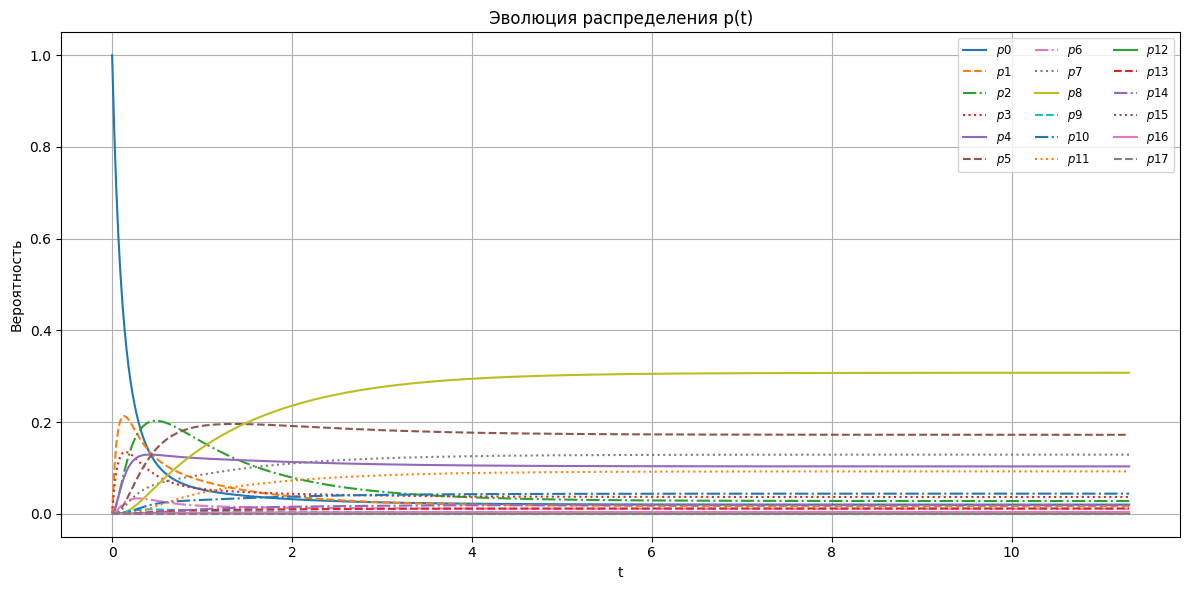

In [72]:
from __future__ import annotations
import numpy as np
from numpy.linalg import lstsq, norm
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


def solve_ctmc(
    Q: np.ndarray,
    initial_state: int = 0,
    rel_tol: float = 0.01,
    method: str = "BDF",
    rtol: float = 1e-8,
    atol: float = 1e-10,
) -> tuple[np.ndarray, np.ndarray, float]:
    """
    Интегрирует систему дифференциальных уравнений ṗ = p Q с использованием метода
    численного интегрирования (по умолчанию 'BDF'), пока не будет выполнен критерий
    сходимости по отношению к стационарному распределению. После нахождения времени τ,
    выполняется интегрирование на интервале [0, 2τ].

    Параметры:
        Q : np.ndarray
            Матрица интенсивностей для цепи Маркова размером (m, m).
        initial_state : int, default 0
            Индекс начального состояния, в котором система находится в момент времени t=0.
        rel_tol : float, default 0.01
            Относительная погрешность для критерия сходимости ‖p(t) - π‖ ≤ rel_tol * ‖π‖.
        method : str, default 'BDF'
            Метод численного интегрирования, используемый в solve_ivp.
        rtol, atol : float, default 1e-8, 1e-10
            Относительная и абсолютная погрешности для solve_ivp.

    Возвращает:
        t : np.ndarray
            Массив времени от 0 до 2τ.
        P : np.ndarray
            Матрица вероятностей состояний системы на каждом временном шаге.
        tau : float
            Время переходного процесса, когда ‖p(t) - π‖ ≤ rel_tol * ‖π‖.
    """
    m = Q.shape[0]  # Размерность матрицы интенсивностей

    # Начальные условия: система начинается в состоянии initial_state
    p0 = np.zeros(m)  # Вектор вероятностей
    p0[initial_state] = 1.0  # Вероятность в начальном состоянии равна 1

    # Нормируем вектор стационарного распределения π
    norm_pi = norm(pi_end)

    # Функция для вычисления правой части системы уравнений ṗ = p Q
    def rhs(t, p):
        return p @ Q

    # Функция для определения события, когда система достигает стационарного распределения
    def ev_conv(t, p):
        return norm(p - pi_end) - rel_tol * norm_pi
    ev_conv.terminal = True  # Останавливаем интегрирование, когда событие срабатывает
    ev_conv.direction = -1.0  # Ожидаем пересечения сверху вниз

    # ---------- Первый прогон: ищем время τ ----------
    sol1 = solve_ivp(
        rhs,
        (0.0, 1e4),  # Интегрируем на длительном интервале для достижения сходимости
        p0,
        method=method,
        rtol=rtol,
        atol=atol,
        events=ev_conv,  # Устанавливаем событие для остановки по достижению сходимости
    )
    
    # Если событие не сработало, то ошибка
    if not sol1.t_events[0].size:
        raise RuntimeError("Критерий сходимости 1 % не достигнут на [0, 1e4].")

    # Получаем время переходного процесса τ
    tau = float(sol1.t_events[0][0])

    # ---------- Второй прогон: интегрируем на интервале [0, 2τ] ----------
    t_eval = np.linspace(0.0, 2.0 * tau, 500)  # Массив временных точек для второй части
    sol2 = solve_ivp(
        rhs,
        (0.0, 2.0 * tau),  # Интегрируем до времени 2τ
        p0,
        method=method,
        t_eval=t_eval,  # Задаем временные точки для вычислений
        rtol=rtol,
        atol=atol,
    )

    return sol2.t, sol2.y, tau  # Возвращаем результат: время, вероятности и τ


if __name__ == "__main__":

    # Генерация матрицы интенсивностей для цепи Маркова, например, из функции build_Q_matrix_cold_standby_numeric
    states, Q = build_Q_matrix_cold_standby_numeric(lambda_A, lambda_B)  # Эта функция должна быть определена вами

    # Решение системы и получение времени τ и соответствующего распределения вероятностей
    t, P, tau = solve_ctmc(Q)  # Вызов функции численного интегрирования

    # Выводим время переходного процесса τ и удвоенное время
    print(f"τ ≈ {tau:.4f},  2τ = {2*tau:.4f}")

    # Построение графика эволюции распределений вероятностей по состояниям
    plt.figure(figsize=(12, 6))
    
    # Используем разные стили линий для различных состояний
    line_styles = ['-', '--', '-.', ':']  # Массив разных стилей линий
    for i, p_i in enumerate(P):
        plt.plot(t, p_i, label=f'$p   {i}$', linestyle=line_styles[i % len(line_styles)])  # Разные стили для разных линий

    plt.xlabel('t')  # Подпись оси X
    plt.ylabel('Вероятность')  # Подпись оси Y
    plt.title('Эволюция распределения p(t)')  # Заголовок графика
    plt.grid(True)  # Включаем сетку
    plt.legend(ncol=3, fontsize='small')  # Легенда
    plt.tight_layout()  # Подгоняем макет
    plt.show()  # Показываем график
